# Odom Calibration

Check the readme to run and generate `odometry_data_xxx_yyy.json`, then analyze with this notebook.

```sh
$ ros2 launch odom_calibration calibrate.launch.py
...
[calibrate-1] [INFO] [1721995879.744634927] [calibrate]: Subscribing to topic "/camera_depth/imu/data" type: ['sensor_msgs/msg/Imu']
[calibrate-1] [INFO] [1721995879.752816777] [calibrate]: Subscribing to topic "/camera_depth/imu/transformed" type: ['sensor_msgs/msg/Imu']
...
[calibrate-1] [INFO] [1721995887.205614831] [calibrate]: {"/camera_depth/imu/data": {"orientation": {"x": 0.0, "y": 0.0, "z": 0.0, "w": 1.0}}, "/camera_depth/imu/transformed": {"orientation": {"x": -0.5000000000000001, "y": 0.5000000000000001, "z": 0.4999999999999999, "w": 0.4999999999999999}}, "/diff_drive_controller/odom": {"position": {"x": 0.0, "y": 0.0, "z": 0.0}, "orientation": {"x": 0.0, "y": 0.0, "z": 0.0, "w": 1.0}}, "/imu_bno08x/data": {"orientation": {"x": 0.00360107421875, "y": -0.0010986328125, "z": 0.88470458984375, "w": 0.46612548828125}}, "/odom": {"position": {"x": -9.754763717599974e-06, "y": 2.161930646390953e-06, "z": 0.0}, "orientation": {"x": 0.0, "y": 0.0, "z": 0.885024220158266, "w": 0.46554498142849}}, "/kiss/odometry": {"position": {"x": -3.7818562381386007, "y": 0.0, "z": 0.0}, "orientation": {"x": 0.0, "y": 0.0, "z": 0.0, "w": 1.0}}, "/scan": 0.273666650056839, "/lidar/cloud": 0.26600000262260437, "/camera_depth/points": 0.3625010480844276}
...
[calibrate-1] Closed file handle for /tmp/odometry_data_20240726_083956.jsonl
[calibrate-1] Printing detailed report:
[calibrate-1] Message counts: {
[calibrate-1]   "/camera_depth/imu/data": 683,
[calibrate-1]   "/camera_depth/imu/transformed": 689,
[calibrate-1]   "/camera_depth/points": 3,
[calibrate-1]   "/diff_drive_controller/odom": 72,
[calibrate-1]   "/imu_bno08x/data": 154,
[calibrate-1]   "/kiss/odometry": 35,
[calibrate-1]   "/lidar/cloud": 69,
[calibrate-1]   "/odom": 133,
[calibrate-1]   "/scan": 66
[calibrate-1] }


```

`/tmp/odometry_data_20240726_083956.jsonl`

In [24]:
!find /tmp -name 'odometry_data_*.json'
ODOM_DATA_FILE = "/tmp/odometry_data_20240726_083956.jsonl"

find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-switcheroo-control.service-BcmHwg’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-colord.service-kBmtuj’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-haveged.service-VSDaMi’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-systemd-resolved.service-OyhYcf’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-upower.service-aZI7Gi’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-ModemManager.service-H8XV3g’: Permission denied
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-systemd-timesyncd.service-vx4C7h’: Permission denied
/tmp/odometry_data_20240726_081730.json
find: ‘/tmp/systemd-private-4326cf122aa84f7286cffd5b8c17167c-systemd-logind.service-8egsnf’: Permission denied
find: ‘/tmp/snap-private-tmp’: Permission denied


In [1]:
!pip install pandas matplotlib seaborn

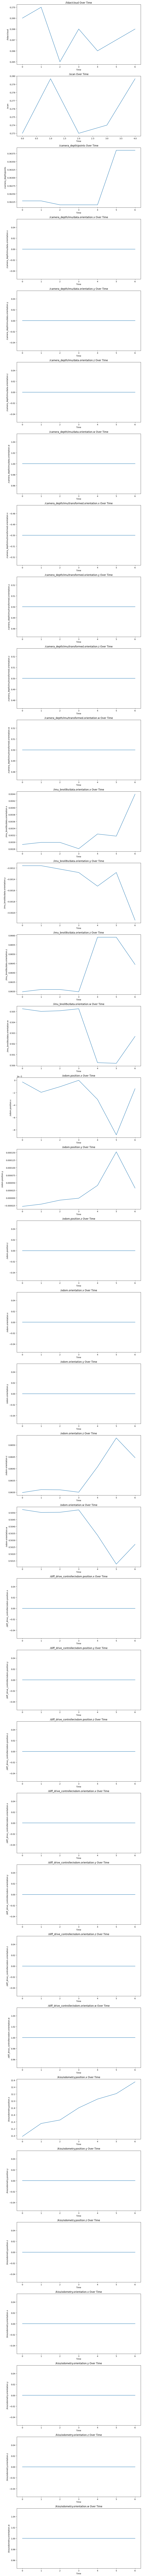

No outliers detected in /lidar/cloud
No outliers detected in /scan
No outliers detected in /camera_depth/points
No outliers detected in /camera_depth/imu/data.orientation.x
No outliers detected in /camera_depth/imu/data.orientation.y
No outliers detected in /camera_depth/imu/data.orientation.z
No outliers detected in /camera_depth/imu/data.orientation.w
No outliers detected in /camera_depth/imu/transformed.orientation.x
No outliers detected in /camera_depth/imu/transformed.orientation.y
No outliers detected in /camera_depth/imu/transformed.orientation.z
No outliers detected in /camera_depth/imu/transformed.orientation.w
Outliers detected in /imu_bno08x/data.orientation.x:
   /lidar/cloud  /scan  /camera_depth/points  \
6         0.268    NaN              0.363849   

   /camera_depth/imu/data.orientation.x  /camera_depth/imu/data.orientation.y  \
6                                   0.0                                   0.0   

   /camera_depth/imu/data.orientation.z  /camera_depth/imu/

In [25]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read JSON Lines file into a pandas DataFrame
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.json_normalize(data)

# Read the JSON Lines file into a DataFrame
df = read_jsonl(ODOM_DATA_FILE)

# Display the first few rows of the DataFrame
df.head()

# Visualize the data
def plot_data(df):
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 5 * len(df.columns)))
    
    for i, column in enumerate(df.columns):
        sns.lineplot(data=df[column], ax=axes[i])
        axes[i].set_title(f'{column} Over Time')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(column)
        
    plt.tight_layout()
    plt.show()

# Detect outliers using the IQR method
def detect_outliers(df):
    outliers = {}
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
    return outliers

# Display outliers
def display_outliers(outliers):
    for column, outlier_data in outliers.items():
        if not outlier_data.empty:
            print(f'Outliers detected in {column}:')
            print(outlier_data)
        else:
            print(f'No outliers detected in {column}')

# Plot the data
plot_data(df)

# Detect and display outliers
outliers = detect_outliers(df)
display_outliers(outliers)
